In [57]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop


In [58]:
class GridBoard:
    def __init__(self, cols, rows):
        self.rows = rows
        self.cols = cols
        self.rewards = pd.DataFrame(np.zeros((rows, cols)))
        self.walls = []
        self.gsize = rows * cols * 5
        for w in self.walls:
        # check here to see if walls within the dataframe boundaries
            if w[0] > -1 and w[0] < grid.cols:
                if w[1] > -1 and w[1] < grid.rows:
                    self.show_board[w[0]][w[1]] = "X"

        self.terminals = []  
        
        self.show_board = pd.DataFrame('.', index=range(self.rows), columns=range(self.cols))

        self.prevq = pd.DataFrame([[[0, 0, 0, 0] for j in range(self.cols)] for i in range(self.rows)], index=range(self.rows), columns=range(self.cols))

        # q_table of the ground truth when q-values converge
        self.qtruth = pd.DataFrame([[[0, 0, 0, 0] for j in range(self.cols)] for i in range(self.rows)], index=range(self.rows), columns=range(self.cols))

        # v table of where the ground truth of v values converage
        self.vtruth = pd.DataFrame(np.zeros((self.rows, self.cols)))
        self.prevv = pd.DataFrame(np.zeros((self.rows, self.cols)))

        self.key = []
        self.door = []

        # Create the numpy array to be the one-hot encoded version to feed into NN
        self.state = np.zeros((self.cols, self.rows, 5))
    
    def assignRewards(self, row, col, reward):
        self.rewards[row][col] = reward
    
    def assignTerminals(self, row, col):
        self.terminals.append([row, col])
    
    def reset_showboard(self):
        self.show_board = pd.DataFrame('.', index=range(self.rows), columns=range(self.cols))
        for w in self.walls:
            if w[0] > -1 and w[0] < grid.cols:
                if w[1] > -1 and w[1] < grid.rows:
                        self.show_board[w[0]][w[1]] = "X"
    
    def set_walls(self, walls):
        for w in walls:
            self.walls.append(w)
    
    def determineQtruth(self, iters, vBool, take1k, m, terms, act, outputact):
        for i in range(0, len(iters)):
            nn = NN('mse', 0.9, act, outputact)
            m = nn.setupNN()
            
            run(False, iters[i], None, 1, True, 'ql', m, terms, None)
            print(player.qtable)
            #run(False, iters[i], None, 1, True, 'ql') 

            if take1k == True:
                if iters[i] == 1000:
                    print(vBool)
                    self.qtruth = player.qtable[:]

                    if vBool == True:
                            print("in there")
                            for i in range(0, len(player.qtable.columns)):
                                for j in range(0, len(player.qtable.index)):                    
                                    v = max(player.qtable[i][j])
                                    self.vtruth[i][j] = v
                    return iters
                
            if i > 0:        
                diffdf = pd.DataFrame([[[0, 0, 0, 0] for j in range(self.cols)] for i in range(self.rows)], index=range(self.rows), columns=range(self.cols))

                for c in range(0, len(player.qtable.columns)):
                    for r in range(0, len(player.qtable.index)):
                        for l in range(0, 4):   
                            diffdf[c][r][l] = round(player.qtable[c][r][l] - self.prevq[c][r][l],2)

                if self.qtruth.equals(diffdf):
                    print("CONVERGENCE!!!")              
                    self.qtruth = player.qtable[:]

                    if vBool == True:
                        print("in there")
                        for i in range(0, len(player.qtable.columns)):
                            for j in range(0, len(player.qtable.index)):                    
                                v = max(player.qtable[i][j])
                                self.vtruth[i][j] = v

                    return(iters)
                
            
            for c in range(0, len(player.qtable.columns)):
                    for r in range(0, len(player.qtable.index)):
                        for l in range(0, 4):   
                            self.prevq[c][r][l] = player.qtable[c][r][l]
            



In [74]:
class Player:
    def __init__(self, grid, start):
        self.start = start
        self.curr_state = self.start[:]
        grid.show_board[self.curr_state[0]][self.curr_state[1]] = "*"
        self.policy = pd.DataFrame(0, index=range(0,grid.rows), columns=range(0,grid.cols))
        self.v = pd.DataFrame(np.zeros((grid.rows, grid.cols)))
        self.vtable = pd.DataFrame(np.zeros((grid.rows, grid.cols)))

        # q_tables are a list within a dataframe cell with the directions [North, East, South, West], always start at 0
        self.qtable = pd.DataFrame([[[0, 0, 0, 0] for j in range(grid.cols)] for i in range(grid.rows)], index=range(grid.rows), columns=range(grid.cols))

        self.gotkey = False
        self.gotdoor = False


    
    def move(self, direct):
        # determine if a move can occur
        # possible values for act: N, S, E, W
        # need next_state to find walls

        if direct == 'N':
            next_state = [self.curr_state[0], self.curr_state[1]-1]
            if self.curr_state[1] != 0 and next_state not in grid.walls: self.curr_state[1] -= 1 

        elif direct == 'E':
            next_state = [self.curr_state[0]+1, self.curr_state[1]]
            if next_state[0] < grid.cols and next_state not in grid.walls: self.curr_state[0] += 1 

        elif direct == 'S':
            next_state = [self.curr_state[0], self.curr_state[1]+1]
            if next_state[1] < grid.rows and next_state not in grid.walls: self.curr_state[1] += 1 

        elif direct == 'W':
            next_state = [self.curr_state[0]-1, self.curr_state[1]]
            if self.curr_state[0] != 0 and next_state not in grid.walls: self.curr_state[0] -= 1 

        else:
            print("Invalid option")

        grid.reset_showboard()
        grid.show_board[self.curr_state[0]][self.curr_state[1]] = '*'
    
    def detNextState(self, curr_state, direct):

        if direct == 'N': next_state = [self.curr_state[0], self.curr_state[1]-1]
        elif direct == 'E': next_state = [self.curr_state[0]+1, self.curr_state[1]]
        elif direct == 'S': next_state = [self.curr_state[0], self.curr_state[1]+1]
        elif direct == 'W': next_state = [self.curr_state[0]-1, self.curr_state[1]]
        else: print("Invalid option")
        
        return next_state    
    
    def findRandDirection(self):
        d = random.randint(1,4)
        if d == 1: return 'N'
        elif d == 2: return 'E'
        elif d == 3: return 'S'
        elif d == 4: return 'W'
        else:
            print("out of bounds")
        
    def detPolicyV(self):
        # determine policy & V table
        
        for i in range(0, len(player.policy.columns)):
            for j in range(0, len(player.policy.index)):
                #print('updating policy')
                #print(player.qtable[i][j])
                dir = player.qtable[i][j].index(max(player.qtable[i][j]))         
                dirv = getDirChar(dir)
                player.policy[i][j] = dirv
                
                v = max(player.qtable[i][j])
                player.v[i][j] = v
            


In [75]:
class QLearn:
    def __init__(self, gamma, lr, deterministic):
        self.gamma = gamma
        self.deterministic = deterministic
        if not deterministic:
            self.lr = lr
        else:
            self.lr = 1
    
    def findQhat(self, rewards, qtable, cs, ns, d):
        qhat = 0
        if self.deterministic == True:
            if ns not in grid.walls:
                qhat = rewards[ns[0]][ns[1]] + self.gamma * max(qtable[ns[0]][ns[1]][0], qtable[ns[0]][ns[1]][1], qtable[ns[0]][ns[1]][2], qtable[ns[0]][ns[1]][3])
        else:
            if ns not in grid.walls:
                qhat = (1-self.lr) * qtable[cs[0]][cs[1]][d] + \
                    self.lr * (rewards[ns[0]][ns[1]] + self.gamma * \
                    max(qtable[ns[0]][ns[1]][0], qtable[ns[0]][ns[1]][1], qtable[ns[0]][ns[1]][2], qtable[ns[0]][ns[1]][3]))

        return qhat
    
    def findSarsa(self, rewards, qtable, cs, ns, d, eps):
        x = ns[0]
        y = ns[1]
        qhat = 0

        # get next action for sarsa
        p = np.random.random()
        if p < (1-eps):
            if ns not in grid.walls:
                if player.policy[x][y] != 0:
                    nextDir = getDirInt(player.policy[x][y])                
                else: 
                    nextDir = getDirInt(player.findRandDirection())
        else: # random
            nextDir = getDirInt(player.findRandDirection())

        if ns not in grid.walls:
            qhat = qtable[cs[0]][cs[1]][d] + self.lr * (rewards[ns[0]][ns[1]] + self.gamma * (qtable[ns[0]][ns[1]][nextDir] - qtable[cs[0]][cs[1]][d]))
            
        return qhat

    def findV(self, rewards, qtable, cs, ns, d):
        # used for TD
        v = 0
        if ns not in grid.walls:
            nextDir = getDirInt(player.policy[ns[0]][ns[1]])
            v = player.vtable[cs[0]][cs[1]] + self.lr * (rewards[ns[0]][ns[1]] + self.gamma * (player.vtable[ns[0]][ns[1]] - player.vtable[cs[0]][cs[1]]))
            
        return v

In [76]:
class Charts():
    def __init__(self, episodes):
        self.stepsGoal = pd.DataFrame(0, columns=['Steps'], index=range(1, episodes+1))
        self.stepsGoal.index.name = 'Episodes'
        self.sse = pd.DataFrame(0, columns=['SSE'], index=range(1, episodes+1))

        self.stepsKey = pd.DataFrame(0, columns=['Key', 'Door', 'Goal'], index=range(1, episodes+1))

    
    def determineSSE(self, type):
        if type == 'q':
            truth = grid.qtruth
            pred = player.qtable
        else:
            truth = grid.vtruth
            pred = player.vtable

        truthList = []
        currentPred = []
        sseVal = 0

        # convert the DF of lists into a big list per DF
        for c in range(0, len(truth.columns)):
            for r in range(0, len(truth.index)):
                truthList.append(truth[c][r])

        for c in range(0, len(pred.columns)):
            for r in range(0, len(pred.index)):
                currentPred.append(pred[c][r])
            
        if type == 'q':
            truthList = [j for i in truthList for j in i]
            currentPred = [j for i in currentPred for j in i]


        for t in range(0, len(truthList)):
            sseVal += (truthList[t] - currentPred[t])**2
        
        return sseVal

In [99]:
class NN():
    def __init__(self, loss, gamma, act, outputact):
        self.loss = loss
        self.gamma = gamma
        self.activation = act
        self.outputact = outputact
        
    
    def setupNN(self):
        model = Sequential()
        model.add(Dense(164, input_shape=(grid.gsize,)))
        model.add(Activation(self.activation))

        model.add(Dense(150, init='lecun_uniform'))
        model.add(Activation(self.activation))

        model.add(Dense(4, init='lecun_uniform'))
        model.add(Activation(self.outputact))

        #model.add(Dense(164, input_shape=(125,)))
        #model.add(Activation('relu'))

        #model.add(Dense(4, init='lecun_uniform'))
        #model.add(Activation('linear'))

        rms = RMSprop()
        model.compile(loss=self.loss, optimizer='Adamax')
        return model
    
    def predict(self, model, ns, type, bs):
        if type == 'predict':
            qval = model.predict(grid.state.reshape(1,grid.gsize), batch_size=bs)
            return qval
        elif type == 'predictMax':
            newQ = model.predict(ns.reshape(1,grid.gsize), batch_size=bs)
            #print(newQ)
            maxQ = np.max(newQ)
            return maxQ
    
    def predictSarsa(self, model, ns, bs, eps):
            newQ = model.predict(ns.reshape(1,grid.gsize), batch_size=bs)
            #print(newQ)
            #print(newQ[0])

            # get next action for sarsa
            p = np.random.random()
            if p < (1-eps):
                direct = getDirChar(np.argmax(newQ))
            else: # random
                direct = player.findRandDirection()
            
            d = getDirInt(direct)

            sarQ = newQ[0][d]
            return sarQ





In [78]:
# function to create gridboard, set up walls & boundaries and assign rewards
# recieves: columns, rows, arewards array for rewards
def setupGrid(columns, rows, arewards, aterminals, key, door):
    grid = GridBoard(columns, rows)
    grid.key = key
    grid.door = door
    
    # create walls and boundaries, treat out of bounds as walls
    for c in range(0, grid.cols):
        grid.walls.append([c, -1])
        grid.walls.append([c, grid.rows])
    for r in range(0, grid.rows):
        grid.walls.append([-1, r])
        grid.walls.append([grid.cols, r])

    for reward in arewards:
        grid.assignRewards(reward[0], reward[1], reward[2])
    
    for terminal in aterminals:
        grid.assignTerminals(terminal[0], terminal[1])

    return grid

In [79]:
def setupState(aTerminals, walls):
    # set goals location
    for terminal in aTerminals:
        grid.state[terminal[0], terminal[1]] = np.array([1,0,0,0,0])

    # set player location
    grid.state[player.curr_state[0], player.curr_state[1]] = np.array([0,1,0,0,0])

    # set wall locations
    if walls != None:
        for wall in walls:
            grid.state[wall[0], wall[1]] = np.array([0,0,1,0,0])

    # set key locations
    if grid.key != None:
        grid.state[grid.key[0], grid.key[1]] = np.array([0,0,0,1,0])

    # set door locations
    if grid.door != None:
        grid.state[grid.door[0], grid.door[1]] = np.array([0,0,0,0,1])

In [80]:
def getDirInt(direct):
    d = 0
    if direct == 'N': d = 0
    elif direct == 'E': d = 1
    elif direct == 'S': d = 2
    elif direct == 'W': d = 3
    return d

def getDirChar(direct):
    d = ''
    if direct == 0: d = 'N'
    elif direct == 1: d = 'E'
    elif direct == 2: d = 'S'
    elif direct == 3: d = 'W'
    return d

In [91]:
# receives: pdef (if predefined path or not), iterations, path (none if not predefined)
def run(pdef, iters, path, eps, getQtruth, alg, model, terms, innerwalls):
    print(f'iters is {iters}')
   
    if pdef == False:
        for i in range(0, iters):
            stepCount = 0
            stepsToKey = 0
            stepsToDoor = 0
            stepsToGoal = 0
            while player.curr_state not in grid.terminals:
                x = player.curr_state[0]
                y = player.curr_state[1]


                qval = nn.predict(model, None, 'predict', 1)
                #print('qval')

                p = np.random.random()
                if p < (1-eps):
                    direct = getDirChar(np.argmax(qval))
                else: # random
                    direct = player.findRandDirection()

                # determine the next state according to the direction chosen
                #next_state = player.detNextState(player.curr_state, direct)
                d = getDirInt(direct)

                # save current state as cstate and then move player so:
                # cstate is the current state and player.curr_state is now the new state
                cstate = player.curr_state[:]
                player.move(direct)
                #print(f'Epsiode {i}')
                #print(f'moving from {cstate} to {player.curr_state}')
                



                # create a copy of the current state, and move player

                #print('before state')
                #print(grid.state)
                nstate = grid.state[:]
                nstate[cstate[0], cstate[1]] = np.zeros(5)
                nstate[player.curr_state[0], player.curr_state[1]] = [0,1,0,0,0]   
                #print('nstate')
                #print(nstate)

                stepCount += 1    

                # update NN grid          

                if alg == 'ql':
                    maxQ = nn.predict(model, nstate, 'predictMax', 1)
                    #print('maxQ')
                    #print(maxQ)
                    # only update qtable if a valid move occurs
                    if player.curr_state != cstate:
                        #player.qtable[x][y][d] = round(maxQ, 4)
                        player.qtable[x][y][d] = maxQ
                    trainQ = maxQ
                elif alg == 'sarsa':
                    sarQ = nn.predictSarsa(model, nstate, 1, eps)
                    #print('sarQ')
                    #print(sarQ)
                    # only update qtable if a valid move occurs
                    if player.curr_state != cstate:
                        player.qtable[x][y][d] = sarQ
                        #player.qtable[x][y][d] = round(sarQ, 4)
                    trainQ = sarQ
                    #qhat = qlearn.findSarsa(grid.rewards, player.qtable, player.curr_state, next_state, d, eps)
                    #qhat = round(qhat, 2)
                    #player.qtable[x][y][d] = qhat
                elif alg == 'td':
                    vhat = qlearn.findV(grid.rewards, player.qtable, player.curr_state, next_state, d)
                    vhat = round(vhat, 2)
                    player.vtable[x][y] = vhat                 



                #print(f'reward is {grid.rewards[player.curr_state[0]][player.curr_state[1]]}')
                #print(f'gamma is {nn.gamma}')
                #print(f'maxQ is {maxQ}')


                tar = np.zeros((1,4))
                tar[:] = qval[:]
                if player.curr_state not in terms:
                    update = (grid.rewards[player.curr_state[0]][player.curr_state[1]] + (nn.gamma * trainQ))
                else:
                    update = grid.rewards[player.curr_state[0]][player.curr_state[1]]  

                tar[0][d] = update         
                
                #print(f'update is {update}')   
                #print(f'direction is {d}')
                #print(f'target is {tar}')
                
                model.fit(grid.state.reshape(1,grid.gsize), tar, batch_size = 1, nb_epoch=1, verbose=0)

                # update state of main grid
                grid.state[:] = nstate[:]
                #print('later grid.state')
                #print(grid.state)

                    
                if player.curr_state == grid.key:
                    player.gotkey = True
                    if grid.door in grid.walls:
                        grid.walls.remove(grid.door)  
                
                if player.curr_state == grid.door:
                    player.gotdoor = True

                if getQtruth == False:
                    # update the steps goal df
                    charts.stepsGoal['Steps'][i+1] = stepCount
                    if player.gotkey == False:                      
                        stepsToKey += 1

                    if player.gotdoor == False:                      
                        stepsToDoor += 1



            if getQtruth == False:
                # determine the new policy and V table
                if alg == 'ql' or alg == 'sarsa':
                    player.detPolicyV()

                # get SSE
                if alg == 'td':
                    charts.sse['SSE'][i+1] = charts.determineSSE('v')
                else:
                    charts.sse['SSE'][i+1] = charts.determineSSE('q')

                charts.stepsKey['Key'][i+1] = stepsToKey
                trueStepsToDoor = stepsToDoor - stepsToKey
                charts.stepsKey['Door'][i+1] = trueStepsToDoor
                charts.stepsKey['Goal'][i+1] = stepCount - (trueStepsToDoor + stepsToKey) 


            # move player back to start position
            player.curr_state = player.start[:]
            # reset door
            if grid.door is not None:
                grid.walls.append(grid.door)
                player.gotkey = False
                player.gotdoor = False
            
            # reset grid
            setupState(terms, innerwalls)

            #if i % 1 == 0:
            print(i, end=' ')

        player.qtable = player.qtable.round(2)
        player.vtable = player.vtable.round(2)               

    
    else:   
        for t in path:            
            for direct in t:
                x = player.curr_state[0]
                y = player.curr_state[1]

                next_state = player.detNextState(player.curr_state, direct)

                d = getDirInt(direct)

                qhat = qlearn.findQhat(grid.rewards, player.qtable, player.curr_state, next_state, d)

                qhat = round(qhat, 2)

                player.qtable[x][y][d] = qhat

                player.move(direct)

            player.curr_state = player.start[:]

        player.qtable = player.qtable.round(2)

In [67]:
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, None, None)
player = Player(grid, [0, 0])
#innerwalls = [[2,0], [2, 1], [2, 3], [2, 4]]
#grid.set_walls(innerwalls)
setupState(aTerminals, None)
print(grid.state)

#print(grid.state)
act = 'sigmoid'
outputact = 'sigmoid'
nn = NN('mse', 0.9, act, outputact)
#print(nn.loss)
#print(nn.model)

m = nn.setupNN()

#sta = grid.state[:]

itersTruth = [500]
grid.determineQtruth(itersTruth, False, False, m, aTerminals, act, outputact)
print("qtruth")
print(grid.qtruth)

[[[0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]]
iters is 500
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 

In [68]:
# Deterministic In class example
aRewards = [[2, 0, 100]]
aTerminals = [[2, 0]]

grid = setupGrid(3, 2, aRewards, aTerminals, None, None)
player = Player(grid, [0, 1])
qlearn = QLearn(0.9, None, True)

itersTruth = [50, 60, 70]
grid.determineQtruth(itersTruth, False, False)

iters = 100

grid.reset_showboard()
player = Player(grid, [0, 1])
charts = Charts(iters)

print(grid.show_board)

run(False, iters, None, 0.1, False, 'ql')
print(player.qtable)
print(grid.show_board)

player.detPolicyV()


plt.figure()
g1 = sns.lineplot(data=charts.stepsGoal)
plt.figure()
g2 = sns.lineplot(data=charts.sse)

TypeError: determineQtruth() missing 4 required positional arguments: 'm', 'terms', 'act', and 'outputact'

[[[0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
iters is 1000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 

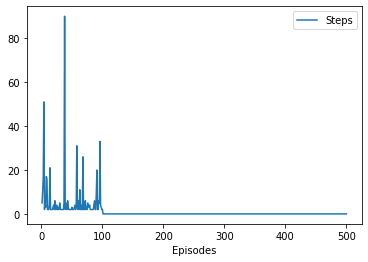

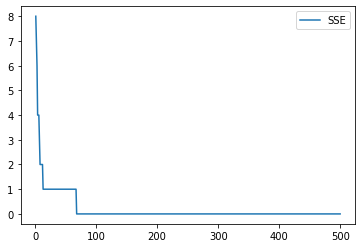

In [69]:
# NN
# Deterministic In class example
aRewards = [[2, 0, 100]]
aTerminals = [[2, 0]]

grid = setupGrid(3, 2, aRewards, aTerminals, None, None)
player = Player(grid, [0, 1])

setupState(aTerminals, None)
print(grid.state)

nn = NN('mse', 0.9, 'sigmoid', 'sigmoid')
m = nn.setupNN()

itersTruth = [1000]
grid.determineQtruth(itersTruth, False, True, m, aTerminals, 'sigmoid', 'sigmoid')

print("qtruth")
print(grid.qtruth)

iters = 100

nn = NN('mse', 0.9, 'sigmoid', 'sigmoid')
m = nn.setupNN()

grid.reset_showboard()
player = Player(grid, [0, 0])
charts = Charts(runiters[i])

print(grid.show_board)

run(False, iters, None, 0.3, False, 'ql', m, aTerminals, None)

print(grid.show_board)

player.detPolicyV()

print(player.policy)
print(player.qtable)

plt.figure()
g1 = sns.lineplot(data=charts.stepsGoal)
plt.figure()
g2 = sns.lineplot(data=charts.sse)

[[[0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]]
iters is 1000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152

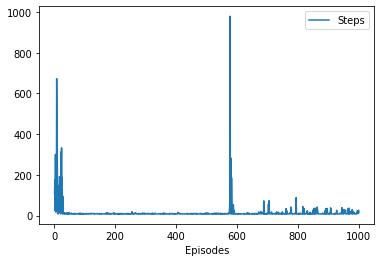

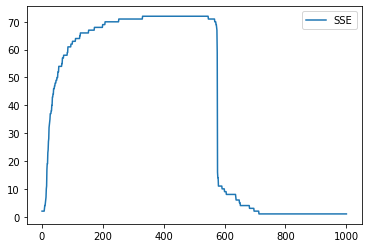

In [72]:
# NN 
# QLearning Nondetrministic
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, None, None)
player = Player(grid, [0, 0])
#innerwalls = [[2,0], [2, 1], [2, 3], [2, 4]]
#grid.set_walls(innerwalls)

setupState(aTerminals, None)
print(grid.state)

#print(grid.state)

nn = NN('mse', 0.9, 'sigmoid', 'sigmoid')
m = nn.setupNN()

#sta = grid.state[:]

itersTruth = [1000]
grid.determineQtruth(itersTruth, False, True, m, aTerminals, 'sigmoid', 'sigmoid')

print("qtruth")
print(grid.qtruth)


runiters = [1000]
for i in range(0, len(runiters)):
    print(i)
    nn = NN('mse', 0.9, 'sigmoid', 'sigmoid')
    m = nn.setupNN()

    grid.reset_showboard()
    player = Player(grid, [0, 0])
    charts = Charts(runiters[i])

    print(grid.show_board)

    run(False, runiters[i], None, 0.1, False, 'ql', m, aTerminals, None)

    print(grid.show_board)

    player.detPolicyV()

    print(player.policy)
    print(player.qtable)

#qlearn = QLearn(0.9, 0.5, False)

#itersTruth = [50, 60, 70, 80]
#grid.determineQtruth(itersTruth, False, False)

#print("qtruth")
#print(grid.qtruth)

qlsteps = charts.stepsGoal[:]
qlsse = charts.sse[:]

plt.figure()
g1 = sns.lineplot(data=qlsteps)
plt.figure()
g2 = sns.lineplot(data=qlsse)




[[[0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]]]
iters is 1000
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152

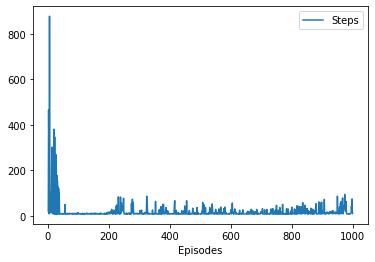

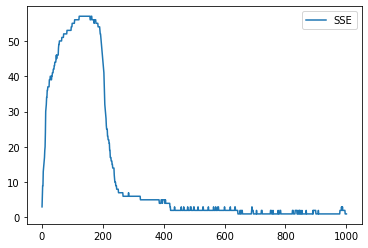

In [103]:
# NN
# SARSA
# uses two actions, use action chosen by eps-greedy rather than max action like Qlearning
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, None, None)
player = Player(grid, [0, 0])

setupState(aTerminals, None)
print(grid.state)


#print(grid.state)
nn = NN('mse', 0.9, 'sigmoid', 'sigmoid')
m = nn.setupNN()

#sta = grid.state[:]

itersTruth = [1000]
grid.determineQtruth(itersTruth, False, True, m, aTerminals, 'sigmoid', 'sigmoid')

print("qtruth")
print(grid.qtruth)




runiters = [1000]
for i in range(0, len(runiters)):
    print(i)
    nn = NN('mse', 0.9, 'sigmoid', 'sigmoid')
    m = nn.setupNN()

    grid.reset_showboard()
    player = Player(grid, [0, 0])
    charts = Charts(runiters[i])

    print(grid.show_board)

    run(False, runiters[i], None, 0.1, False, 'sarsa', m, aTerminals, None)

    print(grid.show_board)

    player.detPolicyV()

    print(player.policy)
    print(player.qtable)

sarsteps = charts.stepsGoal[:]
sarsse = charts.sse[:]

plt.figure()
g1 = sns.lineplot(data=sarsteps)
plt.figure()
g2 = sns.lineplot(data=sarsse)


    

    


0 10 20 30 40 50 60 70 80 90 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 CONVERGENCE!!!
in there
vtruth
       0      1      2      3      4
0  47.81  53.13  59.04   65.6   72.9
1  53.13  59.04  65.60   72.9   81.0
2  59.04  65.60  72.90   81.0   90.0
3  65.60  72.90  81.00   90.0  100.0
4  72.90  81.00  90.00  100.0    0.0
   0  1  2  3  4
0  *  .  .  .  .
1  .  .  .  .  .
2  .  .  .  .  .
3  .  .  .  .  .
4  .  .  .  .  .
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990    0  1  2  3  4
0  .  .  .  .  .
1  .  .  .  .  .
2  .  .  .  .  .
3  .  .  .  .  .
4  .  .  .  .  *


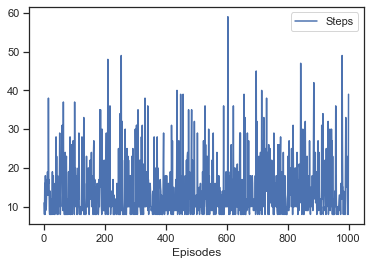

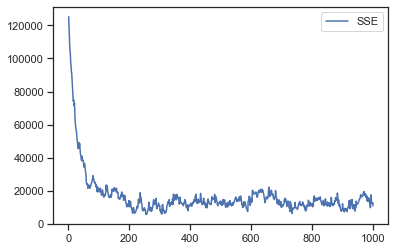

In [22]:
# TD prediction
# Use the V table instead of the Q table, V table is updated on each iteration based on reward location

aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, None, None)
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)

# Create V table
player.v[4][4] = 100

itersTruth = [100, 200, 500, 900]

grid.determineQtruth(itersTruth, True, False)

print("vtruth")
print(grid.vtruth)


runiters = [1000]
for i in range(0, len(runiters)):

    p = [['S', 'E', 'E', 'E', 'S'], ['E', 'S', 'S', 'S', 'W'], ['N', 'E', 'E', 'S', 'S'], ['N', 'W', 'W', 'E', 'S'], ['N', 'W', 'W', 'E', 'N']]
    policy = pd.DataFrame(p)

    grid.reset_showboard()
    player = Player(grid, [0, 0])
    print(grid.show_board)

    player.policy = policy
    charts = Charts(runiters[i])

    run(False, runiters[i], None, 0.3, False, 'td')

    print(grid.show_board)

tdsteps = charts.stepsGoal[:]
tdsse = charts.sse[:]

plt.figure()
g1 = sns.lineplot(data=charts.stepsGoal)
plt.figure()
g2 = sns.lineplot(data=charts.sse)



0 10 20 30 40 0 10 20 30 40 50 0 10 20 30 40 50 60 CONVERGENCE!!!
qtruth
                          0                            1                    2  \
0      [0, 47.81, 47.81, 0]         [0, 0, 53.13, 43.02]         [0, 0, 0, 0]   
1  [43.02, 53.13, 53.13, 0]     [47.81, 0, 59.04, 47.81]         [0, 0, 0, 0]   
2  [47.81, 59.04, 47.81, 0]  [53.13, 65.6, 53.13, 53.13]  [0, 72.9, 0, 59.04]   
3  [53.13, 53.13, 43.02, 0]     [59.04, 0, 47.81, 47.81]         [0, 0, 0, 0]   
4      [47.81, 47.81, 0, 0]         [53.13, 0, 0, 43.02]         [0, 0, 0, 0]   

                          3                       4  
0        [0, 65.6, 65.6, 0]     [0, 0, 72.9, 59.04]  
1    [59.04, 72.9, 72.9, 0]   [65.6, 0, 81.0, 65.6]  
2  [65.6, 81.0, 81.0, 65.6]   [72.9, 0, 90.0, 72.9]  
3     [72.9, 90.0, 90.0, 0]  [81.0, 0, 100.0, 81.0]  
4       [81.0, 100.0, 0, 0]            [0, 0, 0, 0]  
   0  1  2  3  4
0  *  .  X  .  .
1  .  .  X  .  .
2  .  .  .  .  .
3  .  .  X  .  .
4  .  .  X  .  .
0 10 20 30 40 

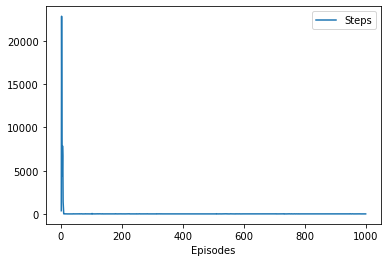

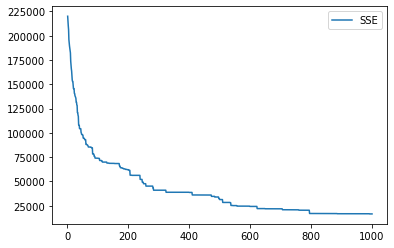

In [14]:
# QLearning Non-deterministic example with walls and one opening
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, None, None)
grid.set_walls([[2,0], [2, 1], [2, 3], [2, 4]])
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)

itersTruth = [50, 60, 70, 80]
grid.determineQtruth(itersTruth, False, False)

print("qtruth")
print(grid.qtruth)

runiters = [1000]
for i in range(0, len(runiters)):

    grid.reset_showboard()
    player = Player(grid, [0, 0])
    charts = Charts(runiters[i])
    print(grid.show_board)

    run(False, runiters[i], None, 0.3, False, 'ql')

    print(grid.show_board)

    player.detPolicyV()

    print(player.policy)

qlwsteps = charts.stepsGoal[:]
qlwsse = charts.sse[:]

plt.figure()
g1 = sns.lineplot(data=qlwsteps)
plt.figure()
g2 = sns.lineplot(data=qlwsse)

    

    


0 10 20 30 40 0 10 20 30 40 50 CONVERGENCE!!!
qtruth
                          0                            1                    2  \
0      [0, 47.81, 47.81, 0]         [0, 0, 53.13, 43.02]         [0, 0, 0, 0]   
1  [43.02, 53.13, 53.13, 0]     [47.81, 0, 59.04, 47.81]         [0, 0, 0, 0]   
2  [47.81, 59.04, 47.81, 0]  [53.13, 65.6, 53.13, 53.13]  [0, 72.9, 0, 59.04]   
3  [53.13, 53.13, 43.02, 0]     [59.04, 0, 47.81, 47.81]         [0, 0, 0, 0]   
4      [47.81, 47.81, 0, 0]         [53.13, 0, 0, 43.02]         [0, 0, 0, 0]   

                          3                       4  
0        [0, 65.6, 65.6, 0]     [0, 0, 72.9, 59.04]  
1    [59.04, 72.9, 72.9, 0]   [65.6, 0, 81.0, 65.6]  
2  [65.6, 81.0, 81.0, 65.6]   [72.9, 0, 90.0, 72.9]  
3     [72.9, 90.0, 90.0, 0]  [81.0, 0, 100.0, 81.0]  
4       [81.0, 100.0, 0, 0]            [0, 0, 0, 0]  
0 10 20 30 40 50 60 70 80 90    0  1  2  3  4
0  .  .  X  .  .
1  .  .  X  .  .
2  .  .  .  .  .
3  .  .  X  .  .
4  .  .  X  .  *
   0 

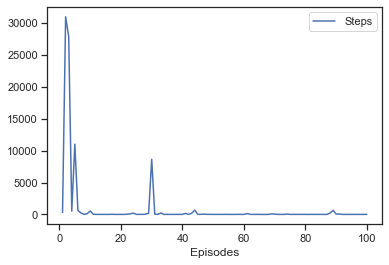

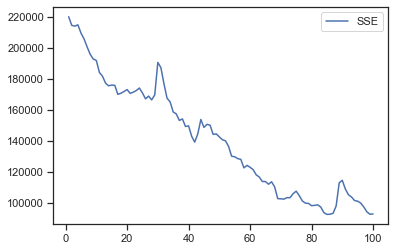

In [127]:
# SARSA with wall with one opening
# predefined policy, not optimal
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, None, None)
grid.set_walls([[2, 0], [2, 1], [2, 3], [2, 4]])
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)

itersTruth = [50, 60, 70, 80]
grid.determineQtruth(itersTruth, False, False)

print("qtruth")
print(grid.qtruth)



runiters = [100]
for i in range(0, len(runiters)):

    #p = [['S', 'E', 'E', 'E', 'S'], ['E', 'S', 'S', 'S', 'W'], ['N', 'E', 'E', 'S', 'S'], ['N', 'W', 'W', 'E', 'S'], ['N', 'W', 'W', 'E', 'N']]
    policy = pd.DataFrame(p)

    grid.reset_showboard()
    player = Player(grid, [0, 0])

    charts = Charts(runiters[i])

    run(False, runiters[i], None, 0.3, False, 'sarsa')

    print(grid.show_board)

    player.detPolicyV()

    print(player.policy)


sarwsteps = charts.stepsGoal[:]
sarwsse = charts.sse[:]

plt.figure()
g1 = sns.lineplot(data=sarwsteps)
plt.figure()
g2 = sns.lineplot(data=sarwsse)


    

    


0 10 20 30 40 50 60 70 80 90 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 CONVERGENCE!!!
in there
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990    0  1  2  3  4
0  .  .  X  .  .
1  .  .  X  .  .
2  .  .  .  .  .
3  .  .  X  .  .
4  .  .  X  .  *


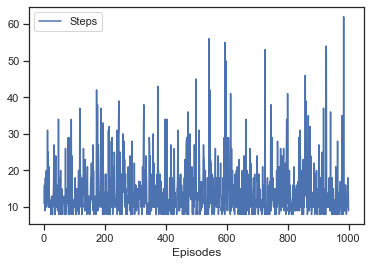

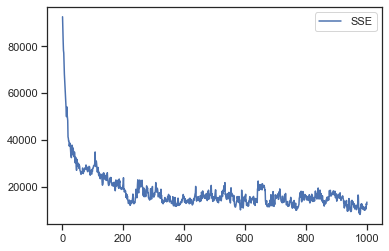

In [23]:
# TD prediction with walls and one opening
# Use the V table instead of the Q table, V table is updated on each iteration based on reward location

aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, None, None)
grid.set_walls([[2, 0], [2, 1], [2, 3], [2, 4]])
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)

# Create V table
player.v[4][4] = 100

itersTruth = [100, 200, 500, 1000]

grid.determineQtruth(itersTruth, True, False)

runiters = [1000]
for i in range(0, len(runiters)):

    p = [['S', 'E', 'E', 'E', 'S'], ['E', 'S', 'S', 'S', 'W'], ['N', 'E', 'E', 'S', 'S'], ['N', 'W', 'W', 'E', 'S'], ['N', 'W', 'W', 'E', 'N']]
    policy = pd.DataFrame(p)
    #print(policy)

    grid.reset_showboard()
    player = Player(grid, [0, 0])

    player.policy = policy
    #print(player.policy)
    charts = Charts(runiters[i])

    run(False, runiters[i], None, 0.3, False, 'td')

    print(grid.show_board)

tdwsteps = charts.stepsGoal[:]
tdwsse = charts.sse[:]

plt.figure()
g1 = sns.lineplot(data=tdwsteps)
plt.figure()
g2 = sns.lineplot(data=tdwsse)



[[0, -1], [0, 5], [1, -1], [1, 5], [2, -1], [2, 5], [3, -1], [3, 5], [4, -1], [4, 5], [-1, 0], [5, 0], [-1, 1], [5, 1], [-1, 2], [5, 2], [-1, 3], [5, 3], [-1, 4], [5, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4]]
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 False
qtruth
                          0                             1  \
0      [0, 47.49, 47.46, 0]          [0, 0, 52.94, 42.67]   
1  [42.14, 52.94, 52.67, 0]      [47.57, 0, 58.86, 47.46]   
2  [45.45, 58.94, 46.56, 0]  [52.87, 65.58, 52.78, 52.27]   
3   [52.51, 52.8, 40.51, 0]      [58.95, 0, 46.24, 46.76]   
4      [46.63, 44.72, 0, 0]          [52.56, 0, 0, 38.98]   

                    

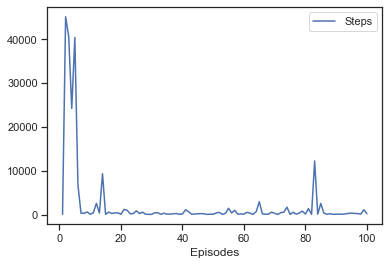

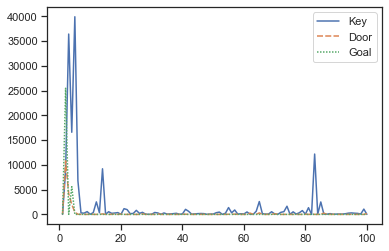

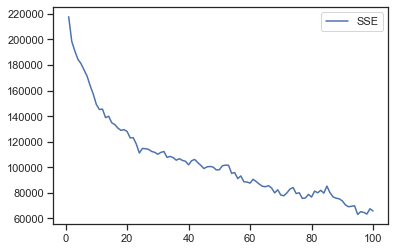

In [15]:
# QLearning Non-deterministic example with walls and with key and door
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, [0, 4], [2, 2])
grid.set_walls([[2, 0], [2, 1], [2, 2], [2, 3], [2, 4]])
print(grid.walls)
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)

itersTruth = [1000]
grid.determineQtruth(itersTruth, False, True)

print("qtruth")
print(grid.qtruth)

runiters = [100]
for i in range(0, len(runiters)):

    player = Player(grid, [0, 0])
    charts = Charts(runiters[i])
    print(grid.show_board)

    run(False, runiters[i], None, 0.3, False, 'ql')

    print(grid.show_board)

    player.detPolicyV()

    print(player.policy)

    print(charts.stepsKey)

qlkeysteps = charts.stepsGoal[:]
qlkeysse = charts.sse[:]
qlkey = charts.stepsKey[:]

plt.figure()
g1 = sns.lineplot(data=qlkeysteps)
plt.figure()
g2 = sns.lineplot(data=qlkey)
plt.figure()
g3 = sns.lineplot(data=qlkeysse)

    

    


[[0, -1], [0, 5], [1, -1], [1, 5], [2, -1], [2, 5], [3, -1], [3, 5], [4, -1], [4, 5], [-1, 0], [5, 0], [-1, 1], [5, 1], [-1, 2], [5, 2], [-1, 3], [5, 3], [-1, 4], [5, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4]]
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 False
qtruth
                          0                            1                    2  \
0      [0, 47.81, 47.81, 0]         [0, 0, 53.13, 43.02]         [0, 0, 0, 0]   
1  [43.02, 53.13, 53.13, 0]     [47.81, 0, 59.04, 47.81]         [0, 0, 0, 0]   
2  [47.81, 59.04, 47.81, 0]  [53.13, 65.6, 53.13, 53.13]  [0, 72.9, 0, 59.04]   
3  [53.13, 53.13, 43.01, 0]      [59.04, 0, 47.8, 47.81]       

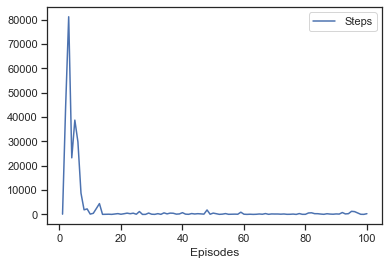

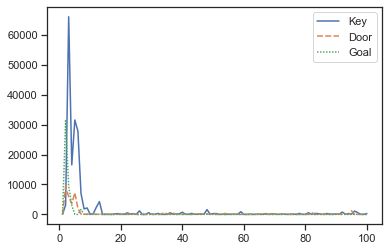

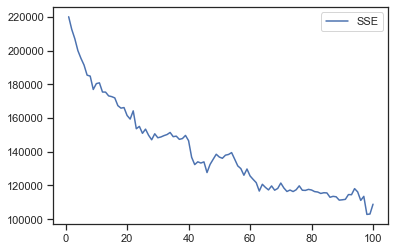

In [16]:
# SARSA with wall with door, key
# predefined policy, not optimal
aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, [0, 4], [2, 2])
grid.set_walls([[2, 0], [2, 1], [2, 2], [2, 3], [2, 4]])
print(grid.walls)
player = Player(grid, [0, 0])
qlearn = QLearn(0.9, 0.5, False)

itersTruth = [1000]
grid.determineQtruth(itersTruth, False, True)

print("qtruth")
print(grid.qtruth)



runiters = [100]
for i in range(0, len(runiters)):
    #p = [['S', 'W', 'X', 'S', 'S'], ['S', 'W', 'X', 'S', 'S'], ['S', 'E', 'E', 'E', 'S'], ['S', 'N', 'X', 'E', 'S'], ['E', 'N', 'X', 'E', 'N']]
    #policy = pd.DataFrame(p)
    #print(policy)

    player = Player(grid, [0, 0])
    #player.policy = policy
    print(player.policy)
    charts = Charts(runiters[i])

    run(False, runiters[i], None, 0.3, False, 'sarsa')

    print(grid.show_board)

    player.detPolicyV()

    print(player.policy)


sarkeysteps = charts.stepsGoal[:]
sarkeysse = charts.sse[:]
sarkey = charts.stepsKey[:]

plt.figure()
g1 = sns.lineplot(data=sarkeysteps)
plt.figure()
g2 = sns.lineplot(data=sarkey)
plt.figure()
g3 = sns.lineplot(data=sarkeysse)


    

    

    

    


[[0, -1], [0, 5], [1, -1], [1, 5], [2, -1], [2, 5], [3, -1], [3, 5], [4, -1], [4, 5], [-1, 0], [5, 0], [-1, 1], [5, 1], [-1, 2], [5, 2], [-1, 3], [5, 3], [-1, 4], [5, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4]]
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 True
in there
vtruth
       0      1     2      3      4
0  44.97  48.18   0.0   65.6   72.9
1  44.54  48.46   0.0   72.9   81.0
2  48.26  57.41  72.9   81.0   90.0
3  47.41  47.55   0.0   90.0  100.0
4  44.31  44.69   0.0  100.0    0.0
   0  1  2  3  4
0  S  W  X  S  S
1  S  W  X  S  S
2  S  E  E  E  S
3  S  N  X  E  S
4  E  N  X  E  N
   0  1  2  3  4
0  S  W  X  S  S
1  S  W  X  S  S
2  S  E  E

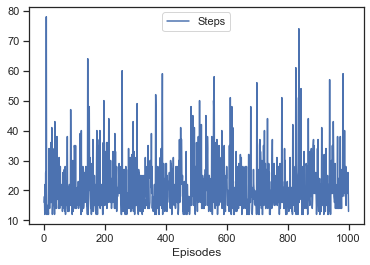

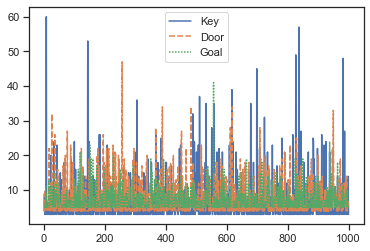

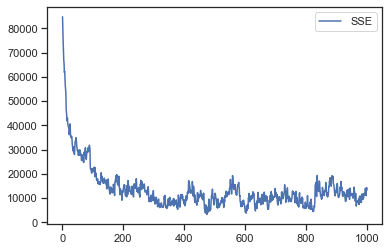

In [24]:
# TD prediction with walls, key, door
# Use the V table instead of the Q table, V table is updated on each iteration based on reward location

aRewards = [[4, 4, 100]]
aTerminals = [[4, 4]]

grid = setupGrid(5, 5, aRewards, aTerminals, [0, 4], [2, 2])
grid.set_walls([[2, 0], [2, 1], [2, 2], [2, 3], [2, 4]])
print(grid.walls)
qlearn = QLearn(0.9, 0.5, False)

# Create V table
player.v[4][4] = 100

itersTruth = [1000]

grid.determineQtruth(itersTruth, True, True)

print("vtruth")
print(grid.vtruth)


runiters = [1000]
for i in range(0, len(runiters)):
    p = [['S', 'W', 'X', 'S', 'S'], ['S', 'W', 'X', 'S', 'S'], ['S', 'E', 'E', 'E', 'S'], ['S', 'N', 'X', 'E', 'S'], ['E', 'N', 'X', 'E', 'N']]
    policy = pd.DataFrame(p)
    print(policy)

    player = Player(grid, [0, 0])
    player.policy = policy
    print(player.policy)
    charts = Charts(runiters[i])

    run(False, runiters[i], None, 0.3, False, 'td')

    print(grid.show_board)

tdkeysteps = charts.stepsGoal[:]
tdkeysse = charts.sse[:]
tdkey = charts.stepsKey

plt.figure()
g1 = sns.lineplot(data=tdkeysteps)
plt.figure()
g2 = sns.lineplot(data=tdkey)
plt.figure()
g3 = sns.lineplot(data=tdkeysse)



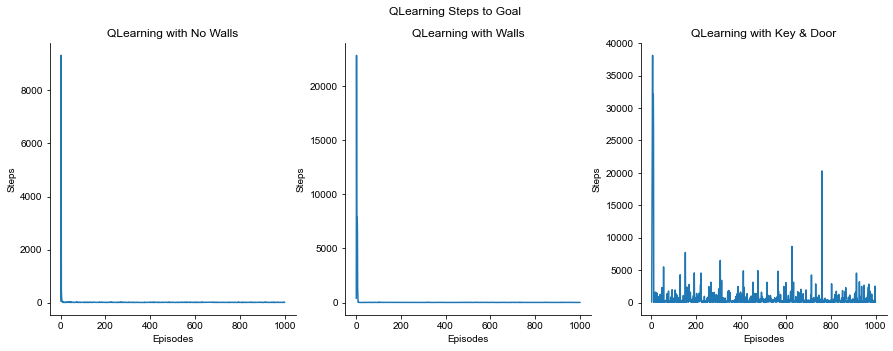

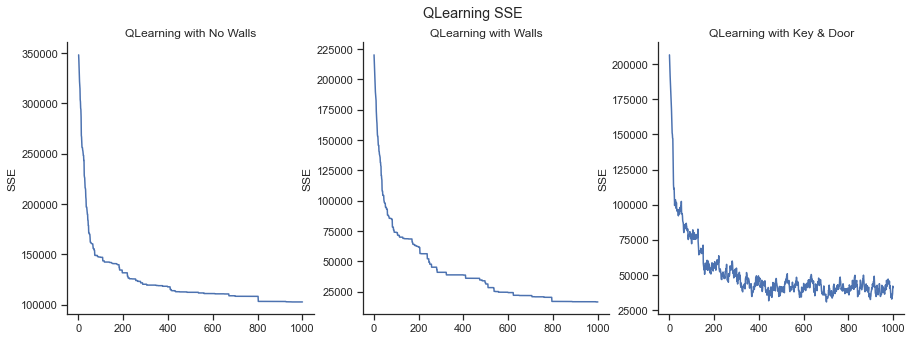

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
fig.suptitle('QLearning Steps to Goal')
ax1, ax2, ax3 = axes.ravel()
sns.set(style="ticks")
sns.despine(fig=fig)

ax1.set_title("QLearning with No Walls")
ax2.set_title("QLearning with Walls")
ax3.set_title("QLearning with Key & Door")

sns.lineplot(x=qlsteps.index, y='Steps', data=qlsteps, ax=ax1)
sns.lineplot(x=qlsteps.index, y='Steps', data=qlwsteps, ax=ax2)
sns.lineplot(x=qlsteps.index, y='Steps', data=qlkeysteps, ax=ax3)

plt.show()

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
fig.suptitle('QLearning SSE')
ax1, ax2, ax3 = axes.ravel()
sns.set(style="ticks")
sns.despine(fig=fig)

ax1.set_title("QLearning with No Walls")
ax2.set_title("QLearning with Walls")
ax3.set_title("QLearning with Key & Door")

sns.lineplot(x=qlsse.index, y='SSE', data=qlsse, ax=ax1)
sns.lineplot(x=qlwsse.index, y='SSE', data=qlwsse, ax=ax2)
sns.lineplot(x=qlkeysse.index, y='SSE', data=qlkeysse, ax=ax3)

plt.show()

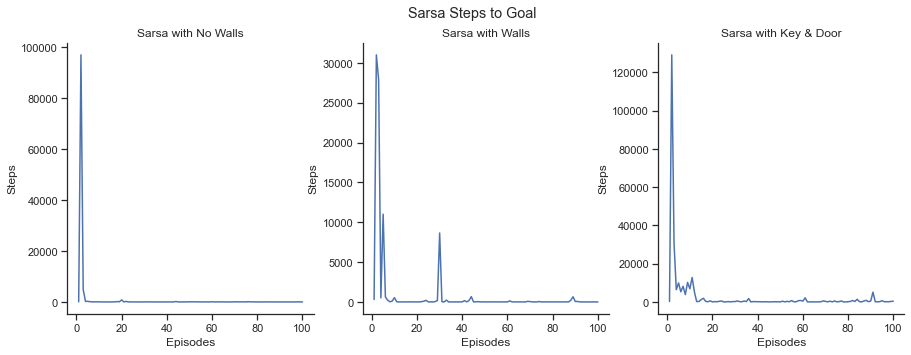

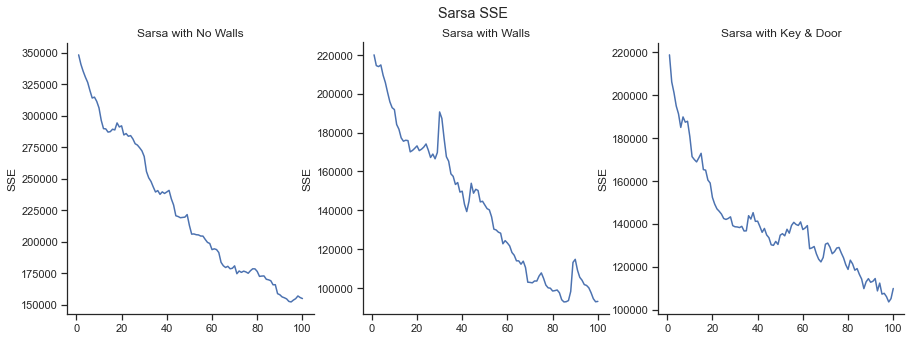

In [129]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
fig.suptitle('Sarsa Steps to Goal')
ax1, ax2, ax3 = axes.ravel()
sns.set(style="ticks")
sns.despine(fig=fig)

ax1.set_title("Sarsa with No Walls")
ax2.set_title("Sarsa with Walls")
ax3.set_title("Sarsa with Key & Door")

sns.lineplot(x=sarsteps.index, y='Steps', data=sarsteps, ax=ax1)
sns.lineplot(x=sarwsteps.index, y='Steps', data=sarwsteps, ax=ax2)
sns.lineplot(x=sarkeysteps.index, y='Steps', data=sarkeysteps, ax=ax3)

plt.show()

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
fig.suptitle('Sarsa SSE')
ax1, ax2, ax3 = axes.ravel()
sns.set(style="ticks")
sns.despine(fig=fig)

ax1.set_title("Sarsa with No Walls")
ax2.set_title("Sarsa with Walls")
ax3.set_title("Sarsa with Key & Door")

sns.lineplot(x=sarsse.index, y='SSE', data=sarsse, ax=ax1)
sns.lineplot(x=sarwsse.index, y='SSE', data=sarwsse, ax=ax2)
sns.lineplot(x=sarkeysse.index, y='SSE', data=sarkeysse, ax=ax3)

plt.show()

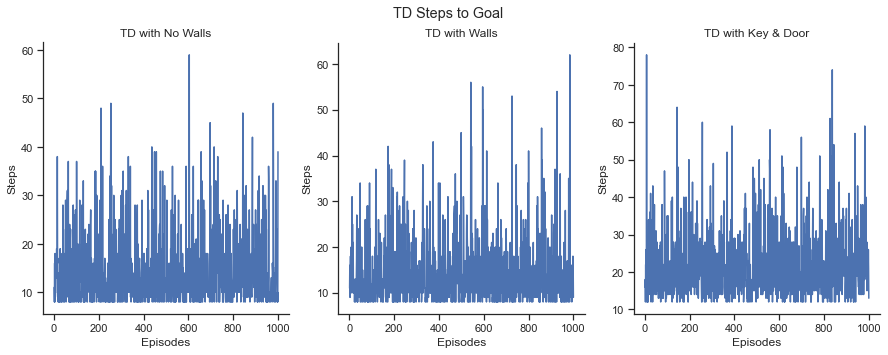

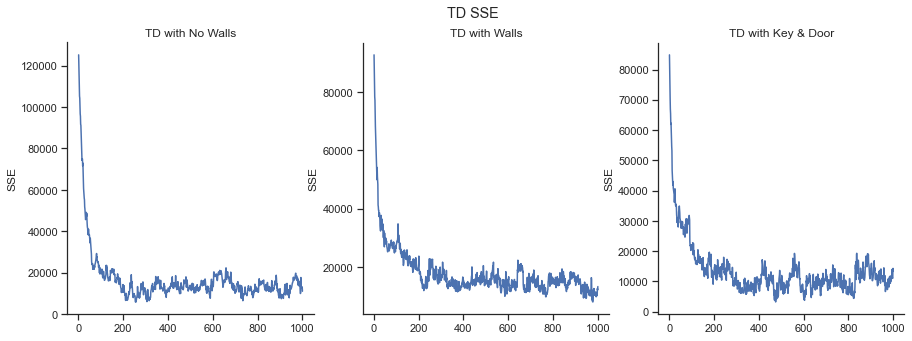

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
fig.suptitle('TD Steps to Goal')
ax1, ax2, ax3 = axes.ravel()
sns.set(style="ticks")
sns.despine(fig=fig)

ax1.set_title("TD with No Walls")
ax2.set_title("TD with Walls")
ax3.set_title("TD with Key & Door")

sns.lineplot(x=tdsteps.index, y='Steps', data=tdsteps, ax=ax1)
sns.lineplot(x=tdwsteps.index, y='Steps', data=tdwsteps, ax=ax2)
sns.lineplot(x=tdkeysteps.index, y='Steps', data=tdkeysteps, ax=ax3)

plt.show()

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
fig.suptitle('TD SSE')
ax1, ax2, ax3 = axes.ravel()
sns.set(style="ticks")
sns.despine(fig=fig)

ax1.set_title("TD with No Walls")
ax2.set_title("TD with Walls")
ax3.set_title("TD with Key & Door")

sns.lineplot(x=tdsse.index, y='SSE', data=tdsse, ax=ax1)
sns.lineplot(x=tdwsse.index, y='SSE', data=tdwsse, ax=ax2)
sns.lineplot(x=tdkeysse.index, y='SSE', data=tdkeysse, ax=ax3)

plt.show()

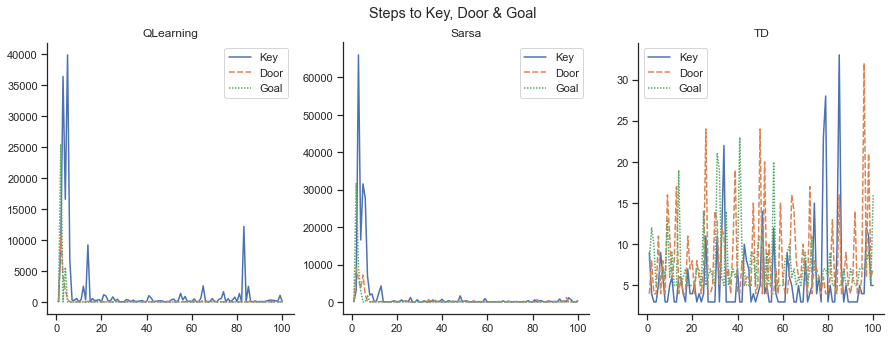

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
fig.suptitle('Steps to Key, Door & Goal')
ax1, ax2, ax3 = axes.ravel()
sns.set(style="ticks")
sns.despine(fig=fig)

ax1.set_title("QLearning")
ax2.set_title("Sarsa")
ax3.set_title("TD")

sns.lineplot(data=qlkey, ax=ax1)
sns.lineplot(data=sarkey, ax=ax2)
sns.lineplot(data=tdkey, ax=ax3)

plt.show()



In [24]:
print(qlsteps)
print(qlsse)

print(qlsteps.describe())
print(qlsse.describe())

          Steps
Episodes       
1            52
2          9322
3           492
4           215
5           146
...         ...
996          16
997           8
998          16
999          16
1000         10

[1000 rows x 1 columns]
         SSE
1     348209
2     342791
3     334497
4     325106
5     321655
...      ...
996   102561
997   102561
998   102561
999   102561
1000  102561

[1000 rows x 1 columns]
             Steps
count  1000.000000
mean     21.892000
std     294.910204
min       8.000000
25%       9.000000
50%      11.000000
75%      13.000000
max    9322.000000
                 SSE
count    1000.000000
mean   122969.924000
std     32256.733781
min    102561.000000
25%    108124.000000
50%    112143.000000
75%    125379.000000
max    348209.000000


In [25]:
print(qlwsteps)
print(qlwsse)

print(qlwsteps.describe())
print(qlwsse.describe())

          Steps
Episodes       
1           376
2         22854
3          8740
4          4381
5          7873
...         ...
996          17
997          10
998           8
999           8
1000         10

[1000 rows x 1 columns]
         SSE
1     220070
2     214651
3     210114
4     206198
5     196080
...      ...
996    16598
997    16598
998    16598
999    16598
1000   16598

[1000 rows x 1 columns]
              Steps
count   1000.000000
mean      65.029000
std      850.779355
min        8.000000
25%       10.000000
50%       11.000000
75%       14.000000
max    22854.000000
                 SSE
count    1000.000000
mean    40884.529000
std     31221.546026
min     16598.000000
25%     20808.000000
50%     31371.000000
75%     47688.000000
max    220070.000000


In [19]:
print(qlkey)
print(qlkeysteps)
print(qlkeysse)
# 50% is the median
print(qlkey.describe())
print(qlkeysteps.describe())
print(qlkeysse.describe())


       Key   Door   Goal
1        6     25     16
2     8844  10817  25478
3    36426   4198     12
4    16592   2019   5606
5    39920    485      5
..     ...    ...    ...
96     246      8      5
97     209      5      7
98      76      4      5
99    1079      7      5
100     11    166      7

[100 rows x 3 columns]
          Steps
Episodes       
1            47
2         45139
3         40636
4         24217
5         40410
...         ...
96          259
97          221
98           85
99         1091
100         184

[100 rows x 1 columns]
        SSE
1    217804
2    198584
3    191043
4    184554
5    181153
..      ...
96    65245
97    64670
98    63431
99    67545
100   65822

[100 rows x 1 columns]
                Key          Door          Goal
count    100.000000    100.000000    100.000000
mean    1640.850000    200.720000    318.630000
std     5793.343567   1168.880575   2602.272813
min        3.000000      4.000000      5.000000
25%       65.750000      4.000000   

In [136]:
print(sarsteps)
print(sarsse)

print(sarsteps.describe())
print(sarsse.describe())

          Steps
Episodes       
1            53
2         96989
3          4873
4           206
5           254
6           110
7            36
8            61
9            68
10           28
11           21
12           14
13           11
14           15
15            8
16           30
17           37
18          152
19           71
20          799
21           31
22          204
23           34
24           21
25            8
26           14
27           14
28            8
29           11
30            8
31           27
32           19
33           25
34           14
35           11
36            9
37           22
38           12
39           16
40            8
41           10
42           12
43           12
44          184
45           12
46           11
47           11
48           31
49            9
50           57
51           57
52           50
53           64
54           20
55           12
56           16
57           20
58           24
59           19
60           75
61      

In [134]:
print(sarwsteps)
print(sarwsse)

print(sarwsteps.describe())
print(sarwsse.describe())

          Steps
Episodes       
1           317
2         31006
3         27907
4           520
5         11021
6           629
7           227
8            29
9           116
10          548
11           31
12           11
13           13
14            9
15           14
16           10
17           23
18           10
19           11
20           11
21           10
22           44
23          100
24          212
25            9
26           19
27           10
28           46
29          183
30         8660
31           40
32           14
33          237
34            8
35           14
36            9
37           14
38           10
39           16
40           15
41          171
42           17
43          190
44          673
45           12
46           23
47           50
48           17
49           15
50           12
51           12
52           10
53           13
54           14
55           13
56            8
57           10
58           16
59           14
60           10
61      

In [20]:
print(sarkey)
print(sarkeysteps)
print(sarkeysse)

# 50% is the median
print(sarkey.describe())
print(sarkeysteps.describe())
print(sarkeysse.describe())

       Key  Door   Goal
1       66    36     13
2     3143  9312  31669
3    66051  5894   9320
4    16559  3641   3073
5    31557  7210     11
..     ...   ...    ...
96    1121     4     36
97     599     4      8
98      13    42     10
99      21     9      9
100    301     8      5

[100 rows x 3 columns]
          Steps
Episodes       
1           115
2         44124
3         81265
4         23273
5         38778
...         ...
96         1161
97          611
98           65
99           39
100         314

[100 rows x 1 columns]
        SSE
1    220068
2    212568
3    207031
4    199956
5    195375
..      ...
96   111127
97   113530
98   102815
99   103049
100  108884

[100 rows x 1 columns]
               Key         Door          Goal
count    100.00000   100.000000    100.000000
mean    1799.35000   360.210000    465.580000
std     7903.74166  1352.193514   3303.300129
min        3.00000     4.000000      5.000000
25%       33.50000     7.750000      5.000000
50%       78

In [26]:
print(tdsteps)
print(tdsse)

print(tdsteps.describe())
print(tdsse.describe())

          Steps
Episodes       
1            11
2             8
3            16
4             8
5            18
...         ...
996          12
997           8
998          10
999           8
1000         39

[1000 rows x 1 columns]
         SSE
1     125218
2     119680
3     114166
4     109627
5     105238
...      ...
996    12897
997    12987
998    12619
999    13050
1000   10998

[1000 rows x 1 columns]
            Steps
count  1000.00000
mean     14.39000
std       7.47501
min       8.00000
25%       9.00000
50%      12.00000
75%      17.00000
max      59.00000
                 SSE
count    1000.000000
mean    16576.620000
std     13283.521775
min      5837.000000
25%     11294.750000
50%     13452.500000
75%     16768.250000
max    125218.000000


In [28]:
print(tdwsteps)
print(tdwsse)

print(tdwsteps.describe())
print(tdwsse.describe())

          Steps
Episodes       
1            11
2            16
3             9
4            15
5            18
...         ...
996          13
997          10
998          18
999          16
1000          9

[1000 rows x 1 columns]
        SSE
1     92691
2     87154
3     82436
4     78322
5     77188
...     ...
996   10660
997   10379
998   12670
999   12136
1000  13335

[1000 rows x 1 columns]
             Steps
count  1000.000000
mean     14.401000
std       7.412094
min       8.000000
25%      10.000000
50%      12.000000
75%      16.250000
max      62.000000
                SSE
count   1000.000000
mean   17778.788000
std     8586.001795
min     8065.000000
25%    13533.250000
50%    15372.500000
75%    18977.000000
max    92691.000000


In [30]:
print(tdkey)
print(tdkeysteps)
print(tdkeysse)

# 50% is the median
print(tdkey.describe())
print(tdkeysteps.describe())
print(tdkeysse.describe())


      Key  Door  Goal
1       4     7     5
2       9     4     5
3       3     4     5
4       6    10     6
5       3     5     5
...   ...   ...   ...
996    10     4     7
997     3     6    10
998    14     6     6
999     9     7     5
1000    3     5     5

[1000 rows x 3 columns]
          Steps
Episodes       
1            16
2            18
3            12
4            22
5            13
...         ...
996          21
997          19
998          26
999          21
1000         13

[1000 rows x 1 columns]
        SSE
1     84838
2     79301
3     74583
4     70468
5     66898
...     ...
996   11589
997   11007
998   13140
999   14322
1000  13329

[1000 rows x 1 columns]
               Key         Door         Goal
count  1000.000000  1000.000000  1000.000000
mean      6.640000     7.542000     7.169000
std       6.575077     5.169619     3.002241
min       3.000000     4.000000     5.000000
25%       3.000000     4.000000     5.000000
50%       4.000000     6.000000     6.0

In [34]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(qlkeysteps)

          Steps
Episodes       
1            70
2         10175
3         17606
4         25825
5         38117
6         19593
7         14760
8         32187
9         26996
10           21
11           65
12          779
13          867
14          170
15          560
16          204
17         1610
18           84
19           43
20          201
21         1546
22           56
23          107
24           71
25         1427
26          145
27          429
28           87
29          290
30           41
31           69
32          888
33          303
34           55
35          373
36           98
37          119
38           55
39         1266
40          722
41           97
42         1014
43          385
44           40
45          137
46          156
47         2313
48          127
49          194
50           44
51          785
52          547
53          509
54         5494
55           32
56          119
57           34
58          307
59          261
60           90
61      

In [41]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(qlkeysteps)

           Steps
Episodes        
1            403
2         135764
3         150370
4           9524
5          25751
6            508
7           1434
8            167
9            362
10            77
11            62
12           601
13            78
14            58
15            20
16            31
17           236
18           149
19           660
20            56
21           312
22            91
23            42
24           312
25           202
26           426
27           147
28           224
29           123
30            82
31            70
32           268
33            30
34          1314
35           239
36            54
37            78
38           216
39            76
40           854
41            19
42            73
43          3728
44           121
45           297
46           201
47          2102
48            52
49           178
50            57
51            96
52          1574
53            95
54           207
55          3737
56            61
57           3

In [85]:
print(player.v)

     0    1     2       3       4
0  0.0  0.0  0.00    0.00    0.00
1  0.0  0.0  0.00    0.00    0.04
2  0.0  0.0  0.00    0.00    0.00
3  0.0  0.0  0.00   22.52  100.00
4  0.0  0.0  0.01  100.00    0.00
